---
title: Telecommunication towers component clasification - Part 1. fastai  
author: "Francisco Mussari"  
date: 2023-03-06  
image: "fastai API levels.PNG"  
categories: [fastai, deeplearning, Walk with fastai, PyTorch]  
format:
  html:
    toc: true
    toc-depth: 3
    
---

## Introduction

The first attempt for developing this idea started as the homework assignment for [lesson 1](https://course.fast.ai/videos/?lesson=1): Deep Learning 2019 (v3) [fast.ai](www.fast.ai) course. 

For that homework I toke my domain expertise on telecommunication towers to build an image clasifier which could hopefuly recognize different tower components.

In may 2022 I was coursing live the 2022 version of the course, which is done in collaboration with [The University of Queensland](https://itee.uq.edu.au/event/2022/practical-deep-learning-coders-uq-fastai) and its now called [Practical Deep Learning for Coders](https://course.fast.ai/).  

I'm running this notebook on an old GTX-1070 NVIDIA GPU.

## Import Libraries

In [ ]:
from fastai.vision.all import *
import timm
import plotly.express as px

## Dataset

I curated an image dataset of multiple towers I worked with in the past several years. And choosed 478 images in 8 relatively "easy" to distinguish categories (components). 

The dataset was stored in google drive and is shared [here](https://drive.google.com/open?id=1Prtb9VbTau8Zk4c4K0YGFfL98MsGuf-F).

### Local Dataset

For the 2022 course, thanks to the help of many great people in fastai forums, I was able to install fastai locally and to use my local GPU on WSL2.

In [ ]:
path = Path("photos")

In [ ]:
train_path = path / 'train'
valid_path = path / 'valid'

labels = [label.parts[-1] for label in train_path.iterdir()]
train_quantity = [len(list(each.iterdir())) for each in train_path.iterdir()]
valid_quantity = [len(list(each.iterdir())) for each in valid_path.iterdir()]
df = pd.DataFrame()

df['label'] = labels * 2
df['set'] = ['train'] * 8 + ['valid'] * 8
df['quantity'] = train_quantity + valid_quantity

In [ ]:
df

,label,set,quantity
0,base_plate,train,87
1,grounding_bar,train,52
2,identification,train,30
3,ladder,train,37
4,light,train,69
5,lightning_rod,train,33
6,platform,train,57
7,transmission_lines,train,29
8,base_plate,valid,29
9,grounding_bar,valid,15


In [ ]:
fig = px.bar(
    df, x="set", y="quantity",
    color='label', barmode='group',
    height=400
)
fig.show()

## The Data

The data was hand picked from a huge tower photoset. To start, I choose these eight easy distinguishable components to be clasified:  
  

- Base plate
- Grounding bar
- Identification
- Ladder
- Light
- Lightning rod
- Platform
- Transmission lines

There are two folders, one for the training (train) and the other for the validation set (valid).

In [ ]:
print(path.ls())   
print('*'*100)
(path/'train').ls()

[Path('photos/train'), Path('photos/valid')]
****************************************************************************************************


(#8) [Path('photos/train/base_plate'),Path('photos/train/grounding_bar'),Path('photos/train/identification'),Path('photos/train/ladder'),Path('photos/train/light'),Path('photos/train/lightning_rod'),Path('photos/train/platform'),Path('photos/train/transmission_lines')]

In [ ]:
tower_parts_fns = get_image_files(path)
tower_parts_fns

(#514) [Path('photos/train/base_plate/Ac102-Corozopando-(64).jpg'),Path('photos/train/base_plate/Ac102-Corozopando-(75).jpg'),Path('photos/train/base_plate/camaguan-087.jpg'),Path('photos/train/base_plate/camaguan-098.jpg'),Path('photos/train/base_plate/cantv el yoco 015.JPG'),Path('photos/train/base_plate/cantv-capanaparo-011.jpg'),Path('photos/train/base_plate/cantv-cinaruco-018.jpg'),Path('photos/train/base_plate/cantv-cinaruco-025.jpg'),Path('photos/train/base_plate/cartanal-(7).jpg'),Path('photos/train/base_plate/CHUSPITA-II-AC-72-MTS-002.jpg')...]

In [ ]:
failed = verify_images(tower_parts_fns)
print(failed)

[]


## DataLoaders

In [ ]:
tower_parts = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)

In [ ]:
dls = tower_parts.dataloaders(path)

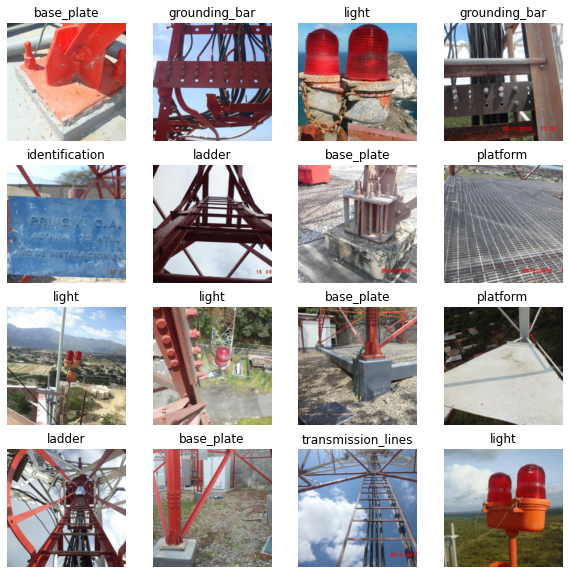

In [ ]:
dls.train.show_batch(max_n=16, nrows=4, figsize=(10,10))

## Learner

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

### fastai's `lr_find`

CPU times: user 21.5 s, sys: 8.07 s, total: 29.6 s
Wall time: 4min 55s


SuggestedLRs(valley=0.0012022644514217973)

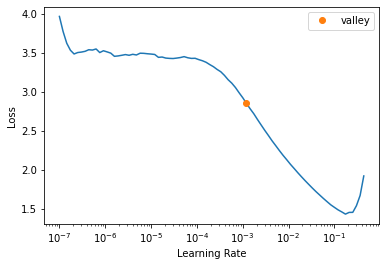

In [ ]:
%%time
learn.lr_find()

In [ ]:
dls.num_workers

1

::: {.callout-note}  
I experimented by setting `dls.num_workers = 4` and it didn't make any difference in the time it takes to run `lr_find()`, even though that by watching at the progress bar it seemed that tha bottleneck was in pre-processing the batch. Not in GPU.
:::

In [ ]:
len(dls.train), len(dls.train.get_idxs())

(6, 394)

In [ ]:
len(dls.valid), len(dls.valid.get_idxs())

(2, 120)

In [ ]:
dls.drop_last

True

## Training

In [ ]:
%%time
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.937233,0.910269,0.308333,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.993036,0.376286,0.100000,00:42
1,0.599209,0.293389,0.066667,00:42
2,0.418232,0.277457,0.058333,00:42


CPU times: user 8.29 s, sys: 4.08 s, total: 12.4 s
Wall time: 2min 48s


In [ ]:
ClassificationInterpretation??

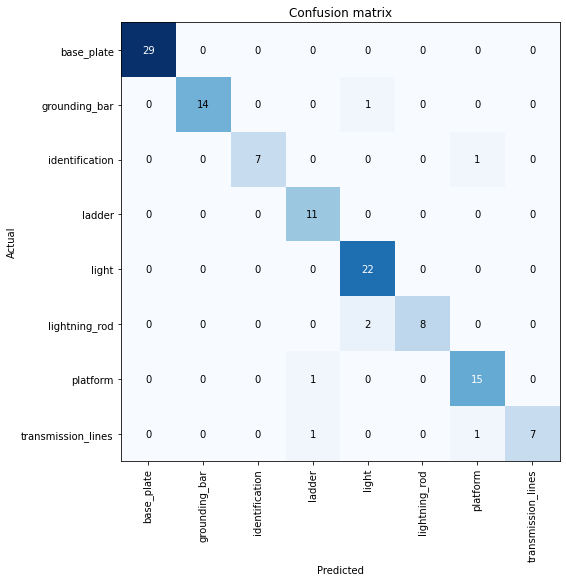

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

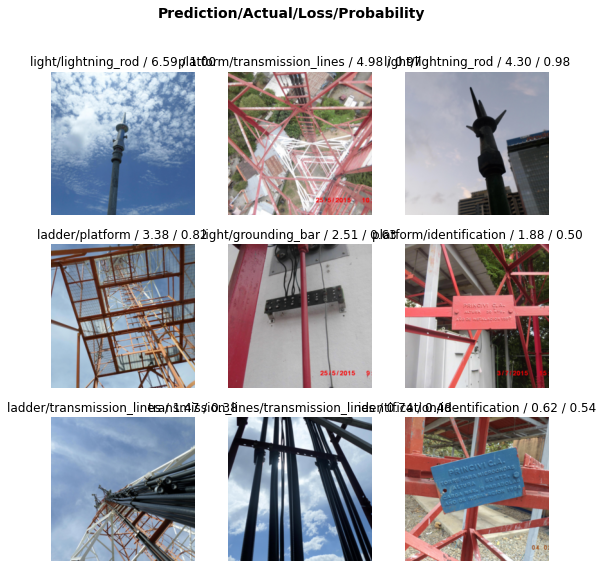

In [ ]:
interp.plot_top_losses(9)

In [ ]:
learn.export('models/tower_parts_model')
learn.save("exported_model_from_fastai", with_opt=False)

Path('models/exported_model_from_fastai.pth')

## Conclusions
- I took less that 500 pictures and 3 epochs to make a small pre-trained model recognize 8 components with an error rate of about 6%.
- `learn.lr_find()` took about 5 minutes to run, more that the fine tuning.
- I'm not sure where in the training process the image normalization occurs. 